# Modelling Rogue Wave Data with Random Forest Classification Model

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [16]:
import os
import sys
import pickle

sys.path.append('./')
import utils

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

from collections import Counter
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Parameter Settings

In [3]:
print(os.cpu_count()) # how many CPU cores are available on the current machine

256


In [4]:
seed = 42
n_jobs = 3

In [ ]:
undersample = True
undersample_method = "random"
num_cv = 10
case = 3

## Building an ElasticNet Regression Model

### Instantiating the Model and Setting Hyperparameters

- `l1_ratio`: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- `selection`: If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

In [5]:
# Define the classifer
classifier = ElasticNet(random_state=seed)

In [6]:
hyperparameter_grid = { 
    'l1_ratio': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1],
    'selection': ['cyclic', 'random'] 
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and PSearman correlation.

We load the case 3 data that was preprocessed in `data_preprocessing.ipynb`.
Case 3: class 0: target < 1.5, class 1: 1.5 < target < 2.0 and class 2: target > 2.0

Building model for case 3
The mean cross-validated score of the best model is 0.012 and the parameters of best prediction model are:
{'l1_ratio': 0, 'selection': 'random'}
Test set MSE: 0.08
Test set R^2: -1.646
Test set Spearman R: 0.007


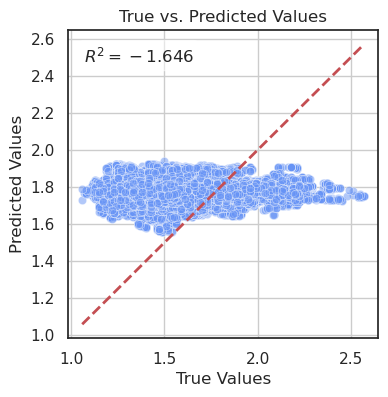

In [ ]:
print(f'Building model for case {case}')

# Load and unpack the data
with open(f'../data/data_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'rb') as handle:
    data = pickle.load(handle)

data_train, data_test = data
y_train = data_train['AI_10min']
y_train_cat = data_train['AI_10min_cat']
X_train = data_train.drop(columns=['AI_10min', 'AI_10min_cat'])
y_test = data_test['AI_10min']
X_test = data_test.drop(columns=['AI_10min', 'AI_10min_cat'])

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

# Tune hyperparameters
skf = StratifiedKFold(n_splits=num_cv).split(X_train_transformed, y_train_cat)

gridsearch_classifier = GridSearchCV(classifier, hyperparameter_grid, cv=skf)
gridsearch_classifier.fit(X_train_transformed, y_train)

# Check the results
print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_, 3)} and the parameters of best prediction model are:')
print(gridsearch_classifier.best_params_)

# Take the best estimator
model = gridsearch_classifier.best_estimator_

# Predict labels
y_pred = model.predict(X_test_transformed)

print(f"Test set MSE: {round(mean_squared_error(y_test, y_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_test, y_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_test, y_pred).correlation, 3)}")

file_plot = f'../results/performance_reg_model_elnet_case{case}{"_undersampled" if undersample else ""}'
utils.plot_predictions(y_true=y_test, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_test, y_pred), 3)}$', save=file_plot)

# Save the model
data_and_model = [data_train, data_test, model]

with open(f'../models/reg_model_elnet_case{case}{"_undersampled" if undersample else ""}.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Building a Random Forest Regression Model

### Instantiating the Model and Setting Hyperparameters

- `n_estimators`: The number of trees in the forest.
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `max_samples`: If bootstrap is True, the number of samples to draw from X to train each base estimator.
- `criterion`: The function to measure the quality of a split. Supported criteria are “squared_error” for the mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node, “friedman_mse”, which uses mean squared error with Friedman’s improvement score for potential splits, “absolute_error” for the mean absolute error, which minimizes the L1 loss using the median of each terminal node, and “poisson” which uses reduction in Poisson deviance to find splits. Training using “absolute_error” is significantly slower than when using “squared_error”.
- `max_features`: The number of features to consider when looking for the best split.

In [8]:
# Define the classifier. We set the oob_score = True, as OOB is a good approximation of the validation set score
classifier = RandomForestRegressor(oob_score=True, random_state=seed)

In [9]:
hyperparameter_grid = {'n_estimators': [1000], 
            'max_depth': [10, 20, 30, 50], 
            'max_samples': [0.8],
            'criterion': ['squared_error', 'poisson','friedman_mse'],
            'max_features': ['sqrt','log2'],
}

### Train and Evaluate the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

For evaluation use MSE, R^2 and PSearman correlation.

We load the case 3 data that was preprocessed in `data_preprocessing.ipynb`.
Case 3: class 0: target < 1.5, class 1: 1.5 < target < 2.0 and class 2: target > 2.0

In [ ]:
print(f'Building model for case {case}')

# Load and unpack the data
with open(f'../data/data_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'rb') as handle:
    data = pickle.load(handle)

data_train, data_test = data
y_train = data_train['AI_10min']
y_train_cat = data_train['AI_10min_cat']
X_train = data_train.drop(columns=['AI_10min', 'AI_10min_cat'])
y_test = data_test['AI_10min']
X_test = data_test.drop(columns=['AI_10min', 'AI_10min_cat'])

# Tune hyperparameters
skf = StratifiedKFold(n_splits=num_cv).split(X_train, y_train_cat)

gridsearch_classifier = GridSearchCV(classifier, hyperparameter_grid, cv=skf)
gridsearch_classifier.fit(X_train, y_train)

# Check the results
print(f'The mean cross-validated score of the best model is {round(gridsearch_classifier.best_score_, 3)} and the parameters of best prediction model are:')
print(gridsearch_classifier.best_params_)

# Take the best estimator
model = gridsearch_classifier.best_estimator_

# Predict labels
y_pred = model.predict(X_test)

print(f"Test set MSE: {round(mean_squared_error(y_test, y_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_test, y_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_test, y_pred).correlation, 3)}")

file_plot = f'../results/performance_reg_model_randomforest_case{case}{"_undersampled" if undersample else ""}'
utils.plot_predictions(y_true=y_test, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_test, y_pred), 3)}$', save=file_plot)

# Save the model
data_and_model = [data_train, data_test, model]

with open(f'../models/reg_model_randomforest_case{case}{"_undersampled" if undersample else ""}.pickle', 'wb') as handle:
    pickle.dump(data_and_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Building model for case 3


### salika, load the rf reg model

In [ ]:
# Load and unpack the data
with open(f'../models/reg_model_randomforest_case{case}{f"_{undersample_method}_undersampled" if undersample else ""}.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

In [18]:
data_train, data_test, rf_reg_model = data_and_model

print(f'Loaded the following model: {rf_reg_model}')

Loaded the following model: RandomForestRegressor(criterion='poisson', max_depth=50, max_features='sqrt',
                      max_samples=0.8, n_estimators=1000, oob_score=True,
                      random_state=42)


In [10]:
y_train = data_train['AI_10min']
y_train_cat = data_train['AI_10min_cat']
X_train = data_train.drop(columns=['AI_10min', 'AI_10min_cat'])
y_test = data_test['AI_10min']
X_test = data_test.drop(columns=['AI_10min', 'AI_10min_cat'])

In [14]:
# print('Training dataset target distribution:')
# print(Counter(y_train))

# print('Test dataset target distribution:')
# print(Counter(y_test))

In [20]:
# Predict labels
y_train_pred = rf_reg_model.predict(X_train)
y_test_pred = rf_reg_model.predict(X_test)

print(f"Test set MSE: {round(mean_squared_error(y_test, y_test_pred), 3)}")
print(f"Test set R^2: {round(r2_score(y_test, y_test_pred), 3)}")
print(f"Test set Spearman R: {round(spearmanr(y_test, y_test_pred).correlation, 3)}")

Test set MSE: 0.057
Test set R^2: -0.891
Test set Spearman R: 0.14


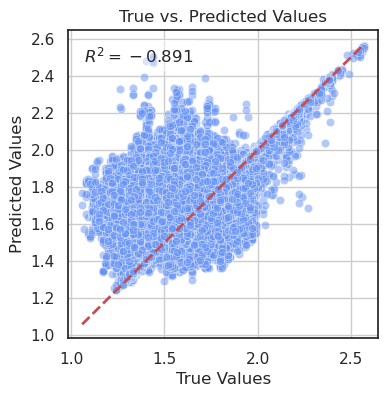

In [21]:
utils.plot_predictions(
    y_true=y_test, y_pred=y_test_pred, 
    textstr = f'$R^2={round(r2_score(y_test, y_pred), 3)}$'
)
